In [6]:
import numpy as np
import pymc as pm

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

In [8]:
df = pd.read_csv('dataset.csv')

In [9]:
df.head()

,Made,Angle,Distance
0,1,54.70,0.72
1,0,63.22,7.14
2,0,88.33,6.91
3,0,79.19,1.36
4,0,10.53,7.33


In [10]:
y = df['Made'].values

x = df[['Angle', 'Distance']].values

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_s = scaler.fit_transform(x)

In [12]:
with pm.Model() as manual_logistic_model:
    # random variables for coefficients with
    # uninformative priors for each parameter

    intercept = pm.Normal('intercept', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.invlogit(intercept + beta_1 * x_s[:, 0] + beta_2 * x_s[:, 1])

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=y)

In [13]:
with manual_logistic_model:
    # compute maximum a-posteriori estimate
    # for logistic regression weights
    manual_map_estimate = pm.find_MAP()

In [14]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})

print_map(manual_map_estimate)

C:\Users\timkm\AppData\Local\Temp\ipykernel_14708\3347572786.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return pd.Series({k: np.asscalar(v) for k, v in result.items()})


intercept   -0.083919
beta_1      -0.040298
beta_2      -0.430417
dtype: float64

---

In [15]:
# normalize values inside df

df['Angle_s'] = (df['Angle'] - df['Angle'].mean()) / df['Angle'].std()
df['Distance_s'] = (df['Distance'] - df['Distance'].mean()) / df['Distance'].std()

In [16]:
import bambi as bmb

In [17]:
df

,Made,Angle,Distance,Angle_s,Distance_s
0,1,54.70,0.72,0.145049,-1.203449
1,0,63.22,7.14,0.459972,1.071748
2,0,88.33,6.91,1.388105,0.990237
3,0,79.19,1.36,1.050266,-0.976638
4,0,10.53,7.33,-1.487594,1.139082
...,...,...,...,...,...
1366,1,0.00,0.52,-1.876811,-1.274327
1367,0,60.91,4.29,0.374588,0.061730
1368,1,26.86,0.83,-0.883993,-1.164466
1369,0,3.42,5.38,-1.750399,0.448018


In [18]:
model = bmb.Model("Made ~ Angle_s + Distance_s", df, family="bernoulli")

In [19]:
model

       Formula: Made ~ Angle_s + Distance_s
        Family: bernoulli
          Link: p = logit
  Observations: 1371
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            Angle_s ~ Normal(mu: 0.0, sigma: 2.5009)
            Distance_s ~ Normal(mu: 0.0, sigma: 2.5009)

In [20]:
fitted = model.fit(draws=2500)

Modeling the probability that Made==1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Angle_s, Distance_s]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2511 seconds.
c:\Users\timkm\AppData\Local\Programs\Python\Python38\lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [21]:
# IMPORT PICKLE

import pickle

with open('fitted_model.pkl', 'wb') as f:
    pickle.dump(fitted, f)


In [30]:
df_mc = fitted.posterior.to_dataframe()

In [33]:
mc = df_mc[['Angle_s', 'Distance_s']].to_numpy()

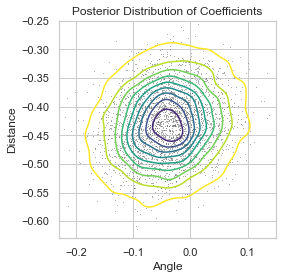

In [123]:
# plot contour plot of the posterior distribution using seaborn

sns.kdeplot(data = df_mc, x='Angle_s', y='Distance_s', fill=False, cmap='viridis_r', levels=10)
sns.scatterplot(data = df_mc.sample(3000), x='Angle_s', y='Distance_s', color='k', alpha=0.5, s=1)
plt.xlabel('Angle')
plt.ylabel('Distance')
plt.title('Posterior Distribution of Coefficients')



plt.xlim(-0.23, 0.15)
plt.ylim(-0.63, -0.25)

# equal axes
plt.gca().set_aspect('equal', adjustable='box')

# plt.show()
plt.savefig('posterior_distribution.svg')

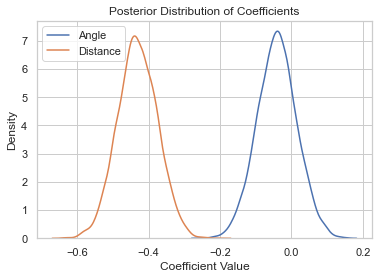

In [99]:
# show each sample on the bottom
sns.kdeplot(data = df_mc, x='Angle_s', fill=False, label='Angle')
sns.kdeplot(data = df_mc, x='Distance_s', fill=False, label='Distance')
plt.xlabel('Coefficient Value')
plt.ylabel('Density')

plt.title('Posterior Distribution of Coefficients')

plt.legend()

plt.savefig('posterior_distribution_samples.svg')

In [101]:
np.mean(np.abs(df_mc.Angle_s) < np.abs(df_mc.Distance_s))

1.0

In [122]:
np.mean(df_mc.Angle_s > 0)

0.2282

In [54]:
df_small = df.sample(50)
df_small.head()

,Made,Angle,Distance,Angle_s,Distance_s
1114,0,89.76,3.16,1.440962,-0.338733
1243,0,76.38,1.54,0.946401,-0.912848
1364,1,81.66,0.65,1.141564,-1.228256
1036,0,48.33,7.67,-0.090403,1.259575
1141,1,54.36,7.19,0.132482,1.089467


In [105]:
df['Distance'].std()

2.8217342040654696

In [55]:
# normalize values inside df

df_small['Angle_s'] = (df_small['Angle'] - df_small['Angle'].mean()) / df_small['Angle'].std()
df_small['Distance_s'] = (df_small['Distance'] - df_small['Distance'].mean()) / df_small['Distance'].std()

In [56]:

df_small.head()

,Made,Angle,Distance,Angle_s,Distance_s
1114,0,89.76,3.16,1.522919,-0.338001
1243,0,76.38,1.54,1.009032,-0.887319
1364,1,81.66,0.65,1.211821,-1.189106
1036,0,48.33,7.67,-0.068288,1.191276
1141,1,54.36,7.19,0.163307,1.028515


In [57]:
model_small = bmb.Model("Made ~ Angle_s + Distance_s", df_small, family="bernoulli")

In [58]:
model_small

       Formula: Made ~ Angle_s + Distance_s
        Family: bernoulli
          Link: p = logit
  Observations: 50
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            Angle_s ~ Normal(mu: 0.0, sigma: 2.5254)
            Distance_s ~ Normal(mu: 0.0, sigma: 2.5254)

In [59]:
fitted_small = model_small.fit(draws=2500)

Modeling the probability that Made==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Angle_s, Distance_s]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 123 seconds.


In [60]:
with open('fitted_model_small.pkl', 'wb') as f:
    pickle.dump(fitted_small, f)

In [63]:
df_mc_small = fitted_small.posterior.to_dataframe()

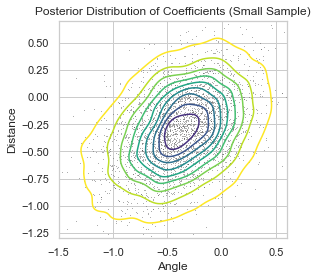

In [124]:
# plot contour plot of the posterior distribution using seaborn

sns.kdeplot(data = df_mc_small, x='Angle_s', y='Distance_s', fill=False, cmap='viridis_r', levels=10)
sns.scatterplot(data = df_mc_small.sample(3000), x='Angle_s', y='Distance_s', color='k', alpha=0.5, s=1)
plt.xlabel('Angle')
plt.ylabel('Distance')
plt.title('Posterior Distribution of Coefficients (Small Sample)')


plt.xlim(-1.5, 0.6)
plt.ylim(-1.3, 0.7)
# equal axes
plt.gca().set_aspect('equal', adjustable='box')

# plt.show()
plt.savefig('posterior_small.svg')

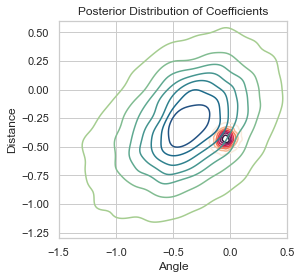

In [76]:
# plot both

sns.kdeplot(data = df_mc, x='Angle_s', y='Distance_s', fill=False, cmap='rocket_r', levels=8)
sns.kdeplot(data = df_mc_small, x='Angle_s', y='Distance_s', fill=False, cmap='crest', levels=8)

plt.xlabel('Angle')
plt.ylabel('Distance')

plt.xlim(-1.5, 0.5)
plt.ylim(-1.3, 0.6)

# equal axes
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Posterior Distribution of Coefficients')

plt.savefig('posterior_comparison.svg')


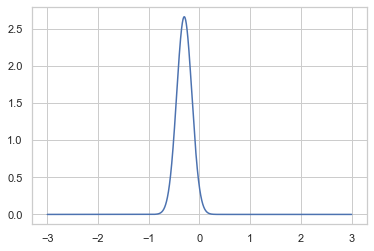

In [119]:
# draw gaussian distribution with mu=-0.3 and sigma=0.1

mu = -0.3
sigma = 0.15

x = np.linspace(-3, 3, 100000)
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

plt.plot(x, y)

In [120]:
# probability of positive for the above

s = np.sum(y)
s

16666.499999999996

In [121]:
np.sum(y[x > 0]) / s

0.022750131228285286